# CNN model with attention block

In [42]:
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import gc
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import time
import seaborn as sns
import torchmetrics
from torchsummary import summary
import gc
from tqdm import tqdm
import cv2 as cv
import torch
from torch import nn


In [43]:
! pip freeze > requirements/requirements.txt

In [44]:
df = pd.read_csv('metadata/data.csv', index_col='Unnamed: 0')
df


,Image Index,Patient Gender_F,Patient Gender_M,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,0.0,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,0.0,1.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2,00000001_002.png,0.0,1.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
4,00000003_000.png,1.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5,00000003_001.png,1.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112097,00030786_007.png,1.0,0.0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
112100,00030789_000.png,1.0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
112106,00030793_000.png,1.0,0.0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
112108,00030795_000.png,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [45]:
df_finding_labels = df.iloc[:,3:]
df_finding_labels

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2,0,1,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112097,0,0,1,0,0,0,0,0,0,0,0,1,0,0
112100,0,0,0,0,0,0,0,0,1,0,0,0,0,0
112106,0,0,0,0,0,0,0,0,0,1,1,0,0,0
112108,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [46]:
# get images
import glob
images_names = np.array(glob.glob('data/images_*/images/*.png'))[df.index]
N = len(images_names)
print("The dataset contains {} images.".format(N))
images_names


The dataset contains 51759 images.


array(['data\\images_001\\images\\00000001_000.png',
       'data\\images_001\\images\\00000001_001.png',
       'data\\images_001\\images\\00000001_002.png', ...,
       'data\\images_012\\images\\00030793_000.png',
       'data\\images_012\\images\\00030795_000.png',
       'data\\images_012\\images\\00030801_001.png'], dtype='<U39')

In [47]:
# images = []
# IMG_SIZE = 1024 // 4
# for x in images_names : 
#         im  = cv.resize(cv.imread(x)[:,:,0], (IMG_SIZE, IMG_SIZE))
#         im = (im - im.min())/(im.max() - im.min())
#         images.append(im)


In [48]:
images_names_train, images_names_test, labels_train, labels_test = train_test_split(images_names, df_finding_labels , test_size = 0.05)

In [49]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [50]:
# training parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 64
N_EPOCHS = 40

IMG_SIZE = 1024 // 8
N_CLASSES = 14

In [51]:
class AttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super(AttentionBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)  # 1x1 convolution to reduce channels
        self.softmax = nn.Softmax(dim=2)  # Softmax along spatial dimensions

    def forward(self, x):
        attention_weights = self.conv(x)  # Calculate attention weights
        attention_weights = self.softmax(attention_weights)  # Apply softmax
        attended_features = x * attention_weights  # Apply element-wise multiplication
        return attended_features

# Define your CNN model with attention blocks
class CNNWithAttention(nn.Module):
    def __init__(self):
        super(CNNWithAttention, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.attention1 = AttentionBlock(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.attention2 = AttentionBlock(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.attention3 = AttentionBlock(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * (IMG_SIZE // 8) * (IMG_SIZE // 8), 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, N_CLASSES)

    def forward(self, x):
        x = torch.relu(self.pool1(self.conv1(x)))
        x = self.attention1(x)
        x = torch.relu(self.pool2(self.conv2(x)))
        x = self.attention2(x)
        x = torch.relu(self.pool3(self.conv3(x)))
        x = self.attention3(x)
        x = x.view(-1, 128 * (IMG_SIZE // 8) * (IMG_SIZE // 8))
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x



In [52]:
# Create an instance of the CNN model with attention
model = CNNWithAttention().to(device)
summary(model, (1, IMG_SIZE, IMG_SIZE))




----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             320
         MaxPool2d-2           [-1, 32, 64, 64]               0
            Conv2d-3            [-1, 1, 64, 64]              33
           Softmax-4            [-1, 1, 64, 64]               0
    AttentionBlock-5           [-1, 32, 64, 64]               0
            Conv2d-6           [-1, 64, 64, 64]          18,496
         MaxPool2d-7           [-1, 64, 32, 32]               0
            Conv2d-8            [-1, 1, 32, 32]              65
           Softmax-9            [-1, 1, 32, 32]               0
   AttentionBlock-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]          73,856
        MaxPool2d-12          [-1, 128, 16, 16]               0
           Conv2d-13            [-1, 1, 16, 16]             129
          Softmax-14            [-1, 1,

In [53]:
import torch.optim as optim
torch.manual_seed(RANDOM_SEED)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
accuracy = torchmetrics.Accuracy(task="multilabel", num_labels=N_CLASSES)
f1_score = torchmetrics.F1Score(task="multilabel", num_labels=N_CLASSES)
recall = torchmetrics.Recall(task="multilabel", num_labels=N_CLASSES)
precision = torchmetrics.Precision(task = 'multilabel', num_labels=N_CLASSES, average='weighted')

In [54]:
trainloader = torch.utils.data.DataLoader(list(zip(images_names_train, labels_train.to_numpy())) , batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
                                          
testloader = torch.utils.data.DataLoader(list(zip(images_names_test, labels_test.to_numpy())) , batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)                                          

In [55]:
# next(iter(trainloader))

In [56]:
# for X_batch, y_batch in trainloader :
#     X_batch
#     break 

In [57]:
# inputs

In [ ]:
def train(model, trainloader, testloader, start = 0, stop = N_EPOCHS) : 

    train_loss = []
    train_accuracy = []
    train_recall = []
    train_f1 = []
    train_precision = []
    test_loss = []
    test_accuracy = []
    test_recall = []
    test_f1 = []
    test_precision = []

    
    for epoch in range(start, start + N_EPOCHS):  # loop over the dataset multiple times


        running_loss = 0.0
        running_accuracy = 0.0
        running_recall = 0.0
        running_f1 = 0.0
        running_precision = 0.0

        with tqdm(trainloader, unit='batch', total = len(trainloader)) as tepoch :
            for X_batch, y_batch in tepoch:
                tepoch.set_description(f"Epoch {epoch+1}")

                # get inputs and labels
                labels = y_batch.to(device).float()
                inputs = []
                for x in X_batch : 
                    inputs.append(cv.normalize(cv.resize(cv.imread(x)[:,:,0], (IMG_SIZE, IMG_SIZE)), 0, 255, cv.NORM_MINMAX))
                inputs = np.array(inputs)
                inputs = torch.Tensor(inputs).to(device).reshape((len(inputs), 1, IMG_SIZE,IMG_SIZE))

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # get statistics
                l = loss.item()
                running_loss += l  * len(labels) 
                outputs = torch.sigmoid(outputs)
                acc = accuracy(outputs, labels).item()
                running_accuracy += acc * len(labels)
                rc = recall(outputs, labels).item()     
                running_recall += rc * len(labels)
                f1 = f1_score(outputs, labels).item()
                running_f1 += f1 *len(labels)
                pr = precision(outputs, labels).item()
                running_precision += pr * len(labels)

                tepoch.set_postfix(loss = l, accuracy = acc, f1 = f1, recall = rc, precision = pr)
                time.sleep(1.0)



                # optimize memory
                del inputs
                del labels
                del outputs
                gc.collect()

        # saving model
        path = f"saved_models/att_model_{epoch+1}epochs.pkl"
        torch.save(model.state_dict(), path)
            
        # saving training loss and test loss 
        train_loss.append(running_loss/len(labels_train))
        train_accuracy.append(running_accuracy/len(labels_train))
        train_recall.append(running_recall/len(labels_train))
        train_f1.append(running_f1/len(labels_train))
        train_precision.append(running_precision/len(labels_train))

        test_results = test(model, criterion, testloader)
        test_loss.append(test_results['loss'])
        test_accuracy.append(test_results['accuracy'])
        test_recall.append(test_results['recall'])
        test_f1.append(test_results['f1'])
        test_precision.append(test_results['precision'])

        tepoch.set_postfix(loss = running_loss/len(labels_train), 
                            accuracy = running_accuracy/len(labels_train), 
                            f1 = running_f1/len(labels_train), 
                            recall = running_recall/len(labels_train), 
                            precision = running_precision/len(labels_train))

            
    print('Finished Training')


    return {'model' : model, 
            'training loss' : train_loss, 
            'training accuracy' : train_accuracy, 
            'test loss' : test_loss, 
            'test accuracy' : test_accuracy, 
            'training recall' : train_recall,
            'training f1' : train_f1,
            'training precision' : train_precision,
            'test recall' : test_recall,
            'test f1' : test_f1,
            'test precision' : test_precision
    }

In [ ]:
def test(model, criterion, testloader) : 

    running_loss = 0.0
    running_accuracy = 0.0
    running_recall = 0.0
    running_f1 = 0.0
    running_precision = 0.0
    
    with tqdm(testloader, unit='batch', total = len(testloader)) as tepoch :
        for X_batch, y_batch in tepoch:
            tepoch.set_description(f"Testing")
            # get inputs and labels
            labels = y_batch.to(device).float()
            inputs = []
            for x in X_batch : 
                inputs.append(cv.normalize(cv.resize(cv.imread(x)[:,:,0], (IMG_SIZE, IMG_SIZE)), 0, 255, cv.NORM_MINMAX))
            inputs = np.array(inputs)
            inputs = torch.Tensor(inputs).to(device).reshape((len(inputs), 1, IMG_SIZE,IMG_SIZE))

            outputs = model(inputs)
            # print(outputs)
            loss = criterion(outputs, labels)
            l = loss.item()
            running_loss += l  * len(labels)
            outputs = torch.sigmoid(outputs)
            acc = accuracy(outputs, labels).item()
            running_accuracy += acc * len(labels)
            rc = recall(outputs, labels).item()     
            running_recall += rc * len(labels)
            f1 = f1_score(outputs, labels).item()
            running_f1 += f1 *len(labels)
            pr = precision(outputs, labels).item()
            running_precision += pr * len(labels)
    
            tepoch.set_postfix(loss = l, accuracy = acc, f1 = f1, recall = rc, precision = pr)
            time.sleep(1)
    
    tepoch.set_postfix(loss = running_loss/len(labels_test), 
                            accuracy = running_accuracy/len(labels_test), 
                            f1 = running_f1/len(labels_test), 
                            recall = running_recall/len(labels_test), 
                            precision = running_precision/len(labels_test))

    return {'loss' : running_loss/len(labels_test), 'accuracy' : running_accuracy/len(labels_test), 'recall' : running_recall/len(labels_test), 'f1' : running_f1/len(labels_test), 'precision' : running_precision/len(labels_test)}

In [41]:
results = train(model, trainloader, testloader)
train_loss = results['training loss'] 
train_accuracy = results['training accuracy']
test_loss = results['test loss']
test_accuracy = results['test accuracy']
train_recall = results['training recall']
test_recall = results['test recall']
train_f1 = results['training f1']
train_recall = results['training recall']
test_f1 = results['test f1']
test_recall = results['test recall']
train_precision = results['training precision']
test_precision = results['test precision']

  0%|          | 0/769 [00:05<?, ?batch/s]


KeyboardInterrupt: 

In [61]:
# creating baseline stats to evaluate quality of the training
baseline = {}
targets = torch.Tensor(np.array(df_finding_labels)).to(device)
random_index = torch.randperm(len(df_finding_labels))
random_outputs = targets[random_index]
random_logits = 0.5 * torch.log((1+random_outputs - 1e-8)/(1-random_outputs + 1e-8))
baseline['loss'] = criterion(random_logits, targets).item()
baseline['accuracy'] = accuracy(random_outputs, targets).item()
baseline['recall'] = recall(random_outputs, targets).item() 
baseline['f1'] = f1_score(random_outputs, targets).item()
baseline['precision'] = precision(random_outputs, targets).item()
print(baseline)

{'loss': 1.4676311016082764, 'accuracy': 0.8216735124588013, 'recall': 0.20407509803771973, 'f1': 0.20407509803771973, 'precision': 0.20407511293888092}


In [68]:
random_logits

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 9.5569],
        [0.0000, 9.5569, 9.5569,  ..., 9.5569, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 9.5569, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [19]:
def plot_stats(title, train_loss, train_accuracy, train_f1, train_recall, test_loss, test_accuracy, test_f1, test_recall):

    epochs = np.arange(1,len(train_loss)+1)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (12,10))
    fig.suptitle(title)
    
    ax1.plot(epochs, train_loss, label = 'Training loss')
    ax1.plot(epochs, test_loss, label = 'Testing loss')
    ax1.legend(loc ='upper left')
    ax1.set(xlabel = 'epochs', ylabel = 'loss')
    ax1.set_title('Training and testing loss')

    ax2.plot(epochs, train_accuracy, label = 'Training accuracy') 
    ax2.plot(epochs, test_accuracy, label = 'Test accuracy')
    ax2.legend(loc ='upper left')
    ax1.set(xlabel = 'epochs', ylabel = 'accuracy')
    ax2.set_title('Training and testing accuracy')

    ax3.plot(epochs, train_f1, label = 'Training f1-score')
    ax3.plot(epochs, test_f1, label = 'Testing f1-score')
    ax3.legend(loc ='upper left')
    ax3.set(xlabel = 'epochs', ylabel = 'f1-score')
    ax3.set_title('Training and testing f1-score')

    ax4.plot(epochs, train_recall, label = 'Training recall') 
    ax4.plot(epochs, test_recall, label = 'Test recall')
    ax4.legend(loc ='upper left')
    ax4.set(xlabel = 'epochs', ylabel = 'recall')
    ax4.set_title('Training and testing recall')

    # ax4.plot(epochs, train_recall, label = 'Training recall') 
    # ax4.plot(epochs, test_recall, label = 'Test recall')
    # ax4.legend(loc ='upper left')
    # ax4.set(xlabel = 'epochs', ylabel = 'recall')
    # ax4.set_title('Training and testing recall')


    plt.show()

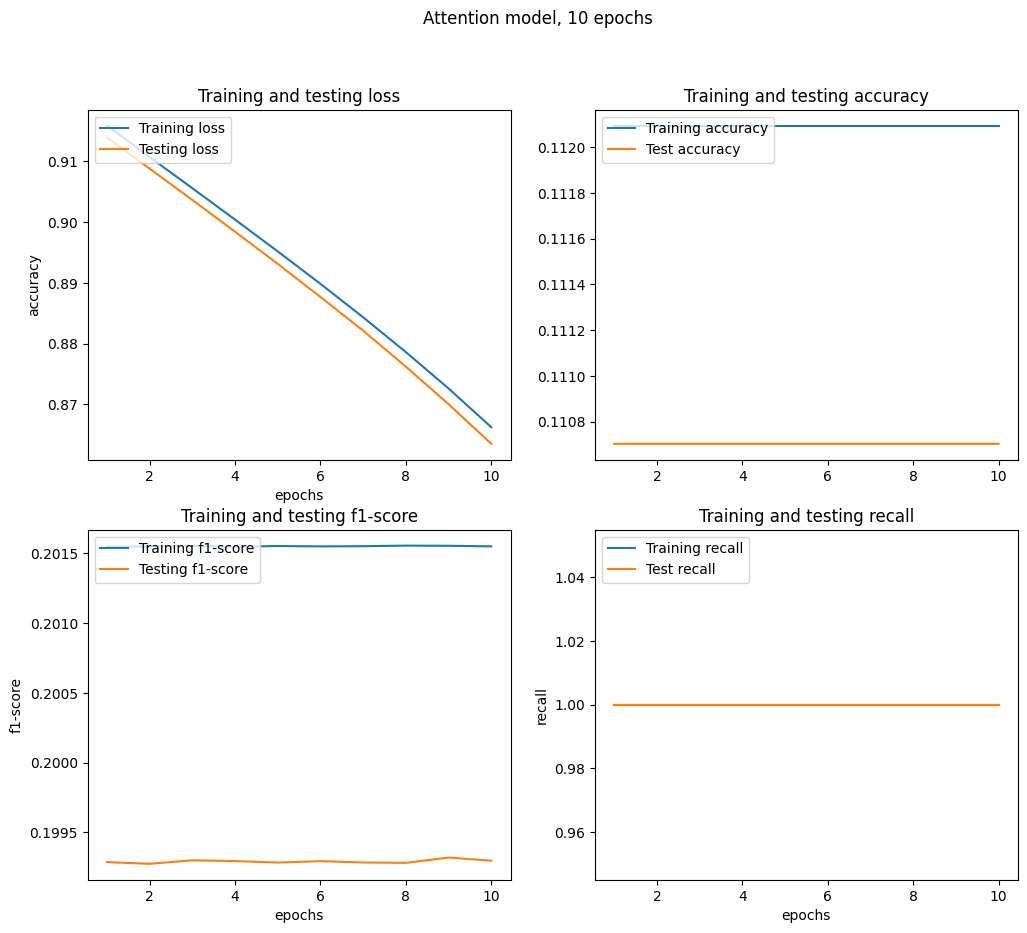

In [24]:
plot_stats('Attention model, 10 epochs', train_loss, train_accuracy, train_f1, train_recall, test_loss, test_accuracy, test_f1, test_recall)

In [69]:
start = 30
stop = 40
model_ = CNNWithAttention().to(device)
path = f"saved_models/att_model_{start}epochs.pkl"
model_.load_state_dict(torch.load(path))
results = train(model_, trainloader, testloader, start, stop)

Epoch 43:  58%|█████▊    | 444/769 [32:06<23:00,  4.25s/batch, accuracy=0.113, f1=0.203, loss=0.863, precision=0.188, recall=1]   

In [36]:
train_loss = results['training loss'] 
train_accuracy = results['training accuracy']
test_loss = results['test loss']
test_accuracy = results['test accuracy']
train_recall = results['training recall']
test_recall = results['test recall']
train_f1 = results['training f1']
train_recall = results['training recall']
test_f1 = results['test f1']
test_recall = results['test recall']
train_precision = results['training precision']
test_precision = results['test precision']

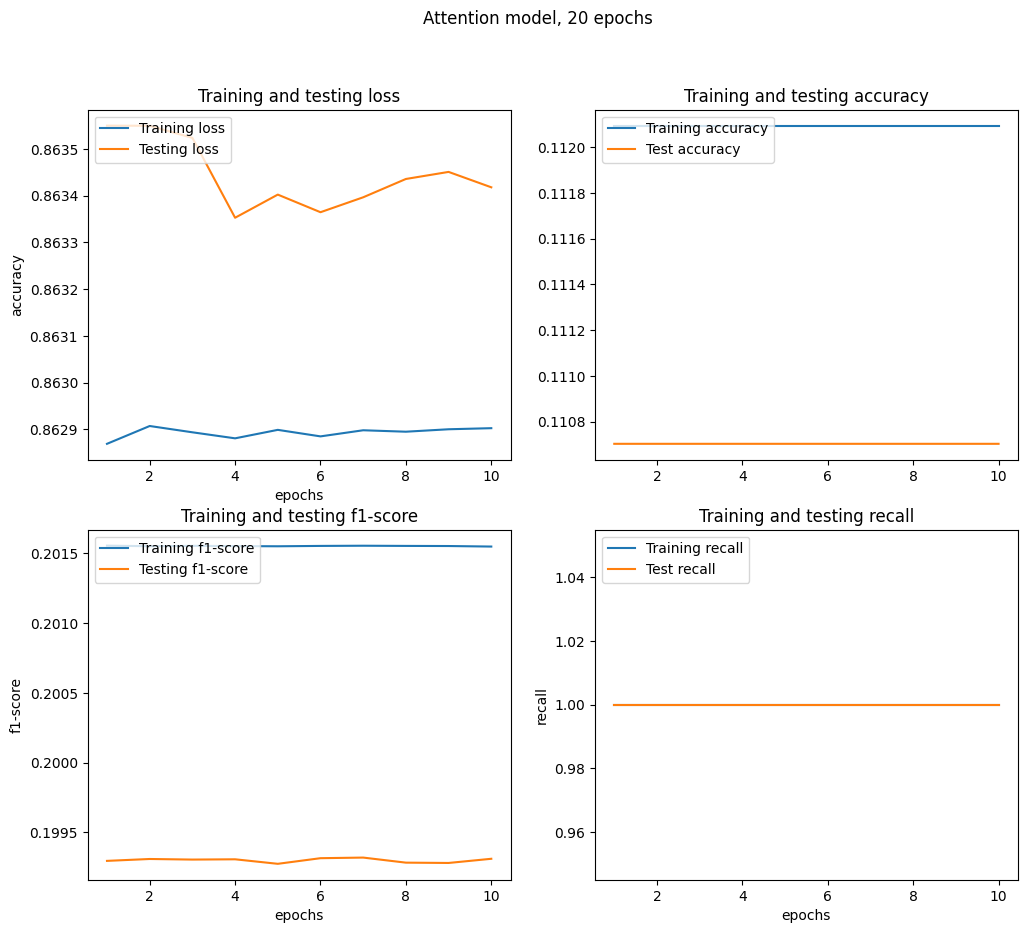

In [37]:
plot_stats('Attention model, 20 epochs', train_loss, train_accuracy, train_f1, train_recall, test_loss, test_accuracy, test_f1, test_recall)

In [38]:
start = 20
stop = 30
model_ = CNNWithAttention().to(device)
path = f"saved_models/att_model_{start}epochs.pkl"
model_.load_state_dict(torch.load(path))
results = train(model_, trainloader, testloader, start, stop)

Testing: 100%|██████████| 21/21 [01:28<00:00,  4.24s/batch, accuracy=0.115, f1=0.206, loss=0.863, precision=0.206, recall=1]

Finished Training


In [39]:
train_loss = results['training loss'] 
train_accuracy = results['training accuracy']
test_loss = results['test loss']
test_accuracy = results['test accuracy']
train_recall = results['training recall']
test_recall = results['test recall']
train_f1 = results['training f1']
train_recall = results['training recall']
test_f1 = results['test f1']
test_recall = results['test recall']
train_precision = results['training precision']
test_precision = results['test precision']

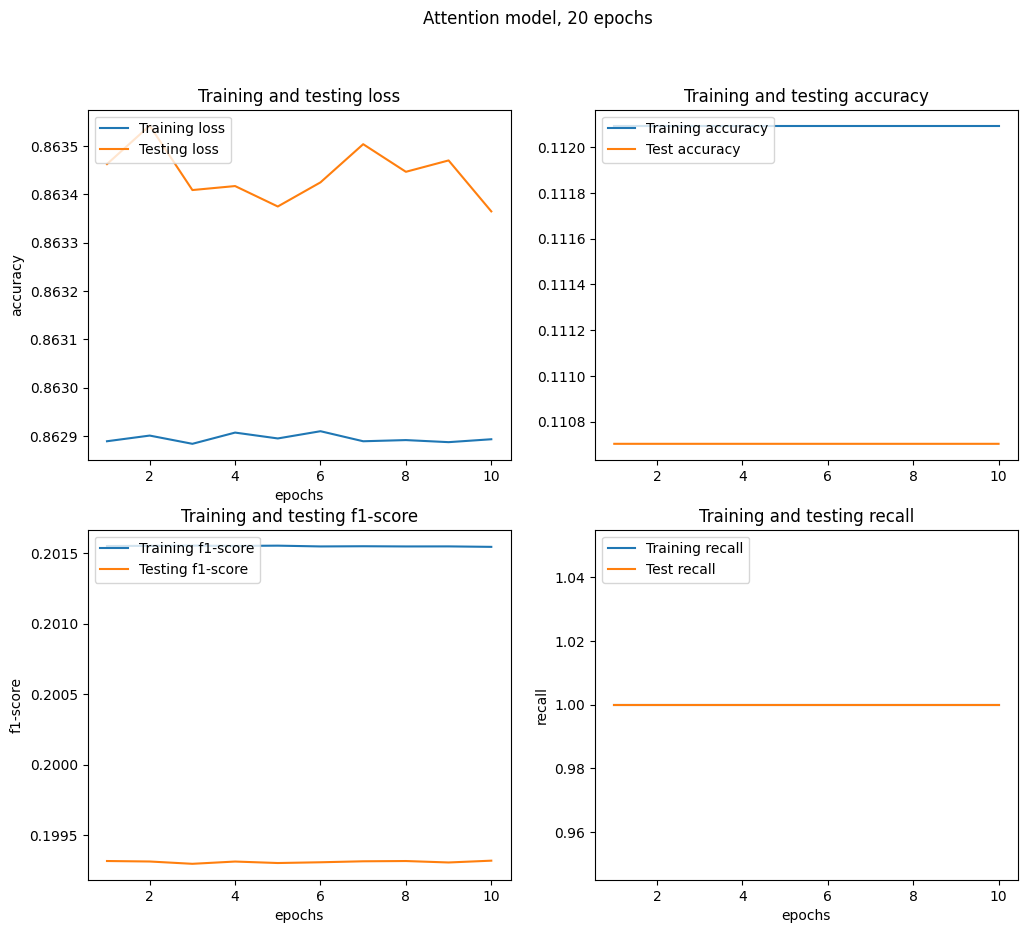

In [40]:
plot_stats('Attention model, 20 epochs', train_loss, train_accuracy, train_f1, train_recall, test_loss, test_accuracy, test_f1, test_recall)

In [39]:
! pip install imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
                                              0.0/235.6 kB ? eta -:--:--
     ------------------------------------- 235.6/235.6 kB 14.1 MB/s eta 0:00:00


In [40]:
from imblearn.metrics import classification_report_imbalanced

def evaluate(model, testloader):

    labels_ = torch.empty((0, N_CLASSES))
    outputs_ = torch.empty((0, N_CLASSES))

    with tqdm(testloader, unit='batch', total = len(testloader)) as tepoch :
        for X_batch, y_batch in tepoch:
            tepoch.set_description(f"Testing")
            # get inputs and labels
            labels = y_batch.to(device).float()
            labels_ = torch.cat((labels_,labels),0)
            inputs = []
            for x in X_batch : 
                inputs.append(cv.normalize(cv.resize(cv.imread(x)[:,:,0], (IMG_SIZE, IMG_SIZE)), 0, 255, cv.NORM_MINMAX))
            inputs = np.array(inputs)
            inputs = torch.Tensor(inputs).to(device).reshape((len(inputs), 1, IMG_SIZE,IMG_SIZE))

            outputs = model(inputs)
            outputs = 1*(torch.sigmoid(outputs)>0.5)
            outputs_ = torch.cat((outputs_,outputs), 0)

    print(classification_report_imbalanced(
    labels_.detach().numpy(),
    outputs_.detach().numpy(),
    output_dict=False,
    target_names=list(df_finding_labels.columns)
    ))

In [34]:
start = 30
model = CNNWithAttention().to(device)
path = f"saved_models/att_model_{start}epochs.pkl"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [35]:
evaluate(model, testloader)

Testing: 100%|██████████| 41/41 [00:53<00:00,  1.30s/batch]

                    precision    recall  f1-score   support

       Atelectasis       0.22      1.00      0.36       571
      Cardiomegaly       0.05      1.00      0.10       135
     Consolidation       0.10      1.00      0.18       259
             Edema       0.04      1.00      0.09       116
          Effusion       0.27      1.00      0.42       690
         Emphysema       0.04      1.00      0.08       105
          Fibrosis       0.03      1.00      0.05        68
            Hernia       0.00      1.00      0.01        12
      Infiltration       0.39      1.00      0.56      1016
              Mass       0.11      1.00      0.19       277
            Nodule       0.12      1.00      0.21       306
Pleural_Thickening       0.08      1.00      0.14       199
         Pneumonia       0.03      1.00      0.06        74
      Pneumothorax       0.10      1.00      0.18       254

         micro avg       0.11      1.00      0.20      4082
         macro avg       0.11      1.0

In [41]:
evaluate(model, testloader)

Testing: 100%|██████████| 41/41 [00:56<00:00,  1.37s/batch]


ValueError: imblearn does not support multilabel

In [ ]:
# outputs = results['predictions'].detach().numpy()

In [ ]:
histo = [np.sum(outputs[:,i]) for i in range(14)]
plt.figure(figsize = (9, 3))
plt.stairs(histo)
plt.xticks(np.arange(0.5,14.5), df_finding_labels.columns, rotation = 90)
plt.title('repartition of the different cases')

In [ ]:
histo = [df_finding_labels[c].sum() for c in df_finding_labels.columns]
plt.figure(figsize = (9, 3))
plt.stairs(histo)
plt.xticks(np.arange(0.5,14.5), df_finding_labels.columns, rotation = 90)
plt.title('repartition of the different cases')

In [ ]:
# X_batch , targets = next(iter(testloader))

# inputs = []
# for x in X_batch : 
#     inputs.append(cv.resize(cv.imread(x)[:,:,0], (IMG_SIZE, IMG_SIZE)))
# inputs = np.array(inputs)
# inputs = torch.Tensor(inputs).to(device).reshape((len(inputs), 1, IMG_SIZE,IMG_SIZE))
        
# outputs = model(inputs)

In [ ]:
# from torch.nn.functional import softmax
# outputs_ = torch.softmax(outputs, 1)


In [ ]:
# outputs_ = outputs_ > outputs_.mean()

In [ ]:
# outputs_ = 1*(outputs_)

In [ ]:
# from torchmetrics import ConfusionMatrix
# confusion_matrix = ConfusionMatrix(task="multilabel", num_labels=14, normalize = 'true')
# cm = confusion_matrix(targets, outputs_)
# cm


In [ ]:
# from torchmetrics import F1Score, Recall
# f1_score = F1Score('multilabel', num_labels = 14)
# f1 = f1_score(targets, outputs_)
# print(f1)
# recall_score = Recall('multilabel', num_labels = 14)
# rc = recall_score(targets, outputs_)
# print(rc)

In [ ]:
# for i,m in enumerate(cm) : 
#     plt.title(f'class {i+1}')
#     sns.heatmap(m, annot = True, )
#     plt.show()

In [ ]:
outputs_.detach().numpy().shape

In [ ]:
# def corr_matrix(y_true, y_hat) : 
targets.detach().numpy().shape

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
y_true = targets.detach().numpy()
y_hat = outputs_.detach().numpy()
cm = multilabel_confusion_matrix(y_true, y_hat)
sns.heatmap(cm)